## Sweep Evaluation

In [1]:
import sys
sys.path.append("../../multicpa")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import seml
from MultiCPA.helper import model_importer
from sklearn.metrics import r2_score

In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
seml_experiments = ["mpert16"]
se = seml_experiments[0]
df_c = seml.get_results(se, to_data_frame=True, states=["COMPLETED"])
df_f = seml.get_results(se, to_data_frame=True, states=["FAILED"])

# todo: fail olanlarin da fail olana kadar results'lari alinsin

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/603 [00:00<?, ?it/s]

  0%|          | 0/603 [00:00<?, ?it/s]

In [7]:
available_splits = ["training", "test", "ood"]
res_cols = ["mean_score_genes", "var_score_genes", 
             "mean_score_genes_de", "var_score_genes_de", 
             "mean_score_proteins", "var_score_proteins"]

for spt in available_splits:
    measurements = pd.DataFrame.from_records(df_c[f"result.{spt}"])
    last_one = []
    for ind, row in measurements.iterrows():
        for tp in row[::-1]:
            if isinstance(tp, list):
                last_one.append(tp)
                break
    assert len(last_one) == len(measurements)
    last_one = pd.DataFrame(last_one, columns=[f"{spt}_{i}_last" for i in res_cols])
    
    dandi = df_c[f"result.{spt}"]
    for tp_i in [0, 2, 4]:
        da = [[timepoint[tp_i] for timepoint in row] for row in dandi]  # 4 for mean_proteins
        df_c[f"{spt}_{res_cols[tp_i]}"] = pd.Series(da)
    
    df_c = pd.concat([df_c, last_one], axis=1)
    df_c["status"] = 1
    df_c.reset_index(drop=True, inplace=True)
    df_f["status"] = 0

for spt in available_splits:
    df_c.drop(columns=[f"result.{spt}"], inplace=True)
df_f.drop(columns=["result"], inplace=True)

df_c.set_index("_id", drop=True, append=False, inplace=True, verify_integrity=True)
df_f.set_index("_id", drop=True, append=False, inplace=True, verify_integrity=True)
df = pd.concat([df_c, df_f], axis=0)
df.sort_index(inplace=True)

In [8]:
df[["config.db_collection", "config.dataset.dataset_args.dataset_path", 'config.dataset.dataset_args.split_key', "config.model.model_type", "status"]].drop_duplicates()

,config.db_collection,config.dataset.dataset_args.dataset_path,config.dataset.dataset_args.split_key,config.model.model_type,status
_id,,,,,
1,mpert16,datasets/Wessel22_prep.h5ad,split2,TotalComPert,0
5,mpert16,datasets/Wessel22_prep.h5ad,split2,TotalComPert,1


In [9]:
df.to_pickle(f"/storage/groups/ml01/workspace/kemal.inecik/seml/{se}/{se}_pickled.pk")

## Quick Look

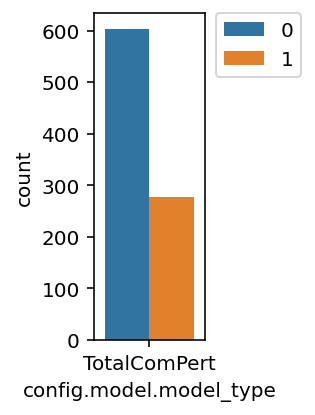

In [10]:
cmmt = list(df["config.model.model_type"].unique())
plt.figure(figsize=(len(cmmt) * 1, 3))
sns.countplot(data=df, x="config.model.model_type", hue="status")
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
plt.show()

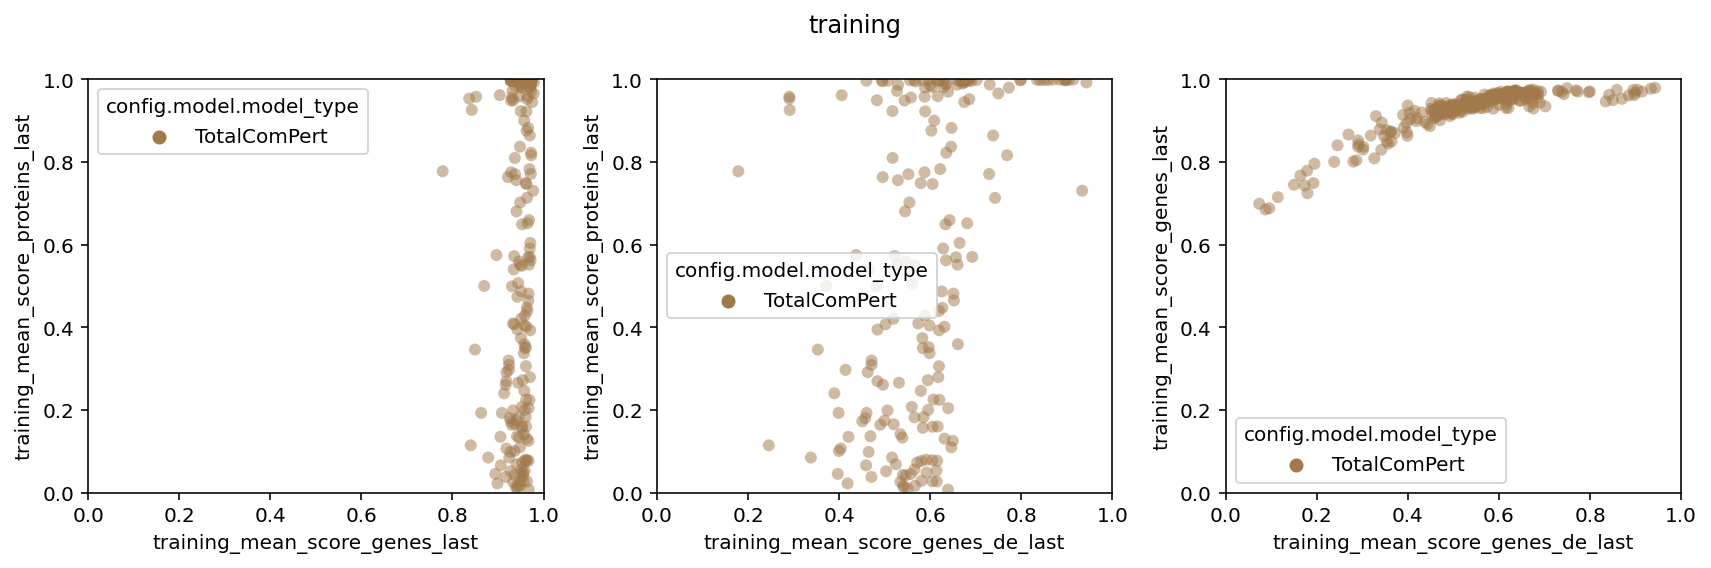

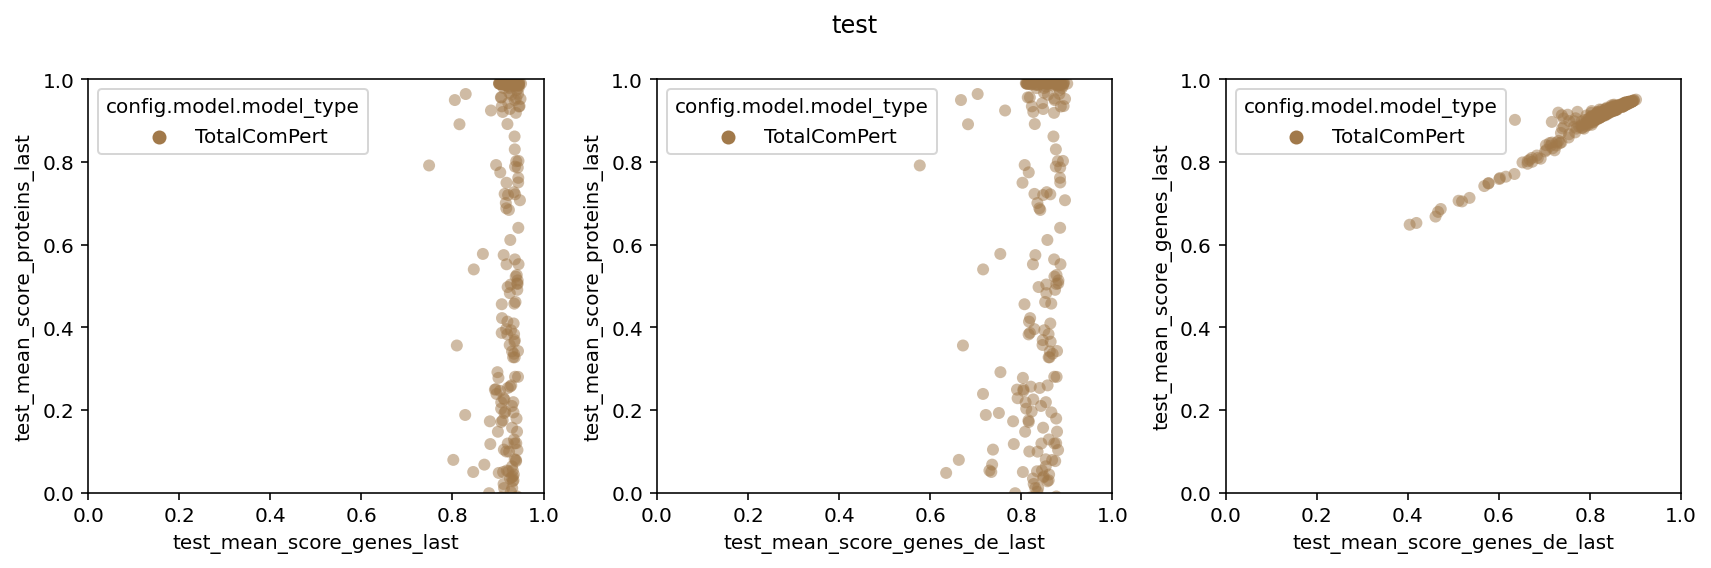

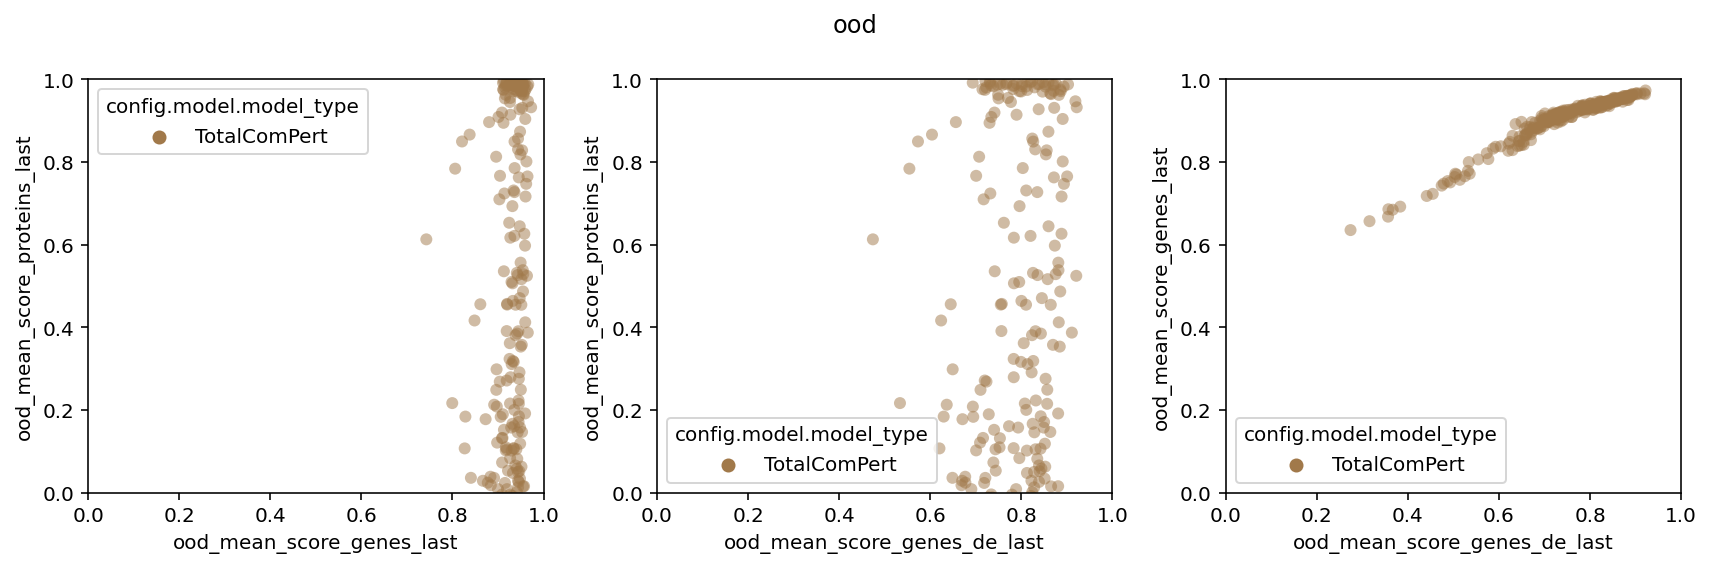

In [11]:
the_df = df[df["status"] == 1]
_sett = {"linewidth":0, "alpha" : 0.5, "sizes":0.01, "palette":"cubehelix"}
for spt in available_splits:
    plt.subplots(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=the_df, x=f"{spt}_mean_score_genes_last", y=f"{spt}_mean_score_proteins_last", hue="config.model.model_type", **_sett)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.subplot(1, 3, 2)
    sns.scatterplot(data=the_df, x=f"{spt}_mean_score_genes_de_last", y=f"{spt}_mean_score_proteins_last", hue="config.model.model_type", **_sett)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=the_df, x=f"{spt}_mean_score_genes_de_last", y=f"{spt}_mean_score_genes_last", hue="config.model.model_type", **_sett)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.suptitle(spt)
    plt.tight_layout()
    plt.show()

In [12]:
fixed_hypers = ["config.model.model_args." + i for i in ["loss_ae", "patience", "decoder_activation", "is_vae"]]
loguinform_hypers = ["config.model.model_args.hparams." + i for i in ["dosers_lr", "dosers_wd", "autoencoder_lr", "autoencoder_wd", "adversary_lr", 
                      "adversary_wd", "reg_adversary", "penalty_adversary", "recon_weight_pro"]]
choice_hypers = [i for i in df.columns if i.startswith("config.model.model")]
choice_hypers = [c for c in choice_hypers if c not in fixed_hypers and c not in loguinform_hypers]

In [13]:
loss_columns = ['result.loss_reconstruction', 'result.loss_adv_drugs', 'result.loss_adv_cell_types', 
                'result.loss_reconstruction_proteins', 'result.loss_reconstruction_genes']
for lc in loss_columns:
    new_column = []
    for ind, row in df.iterrows():
        if row["status"] == 1:
            new_column.append(row[lc][-1])
        else:
            new_column.append(np.nan)
    df[f"{lc}_last"] = new_column

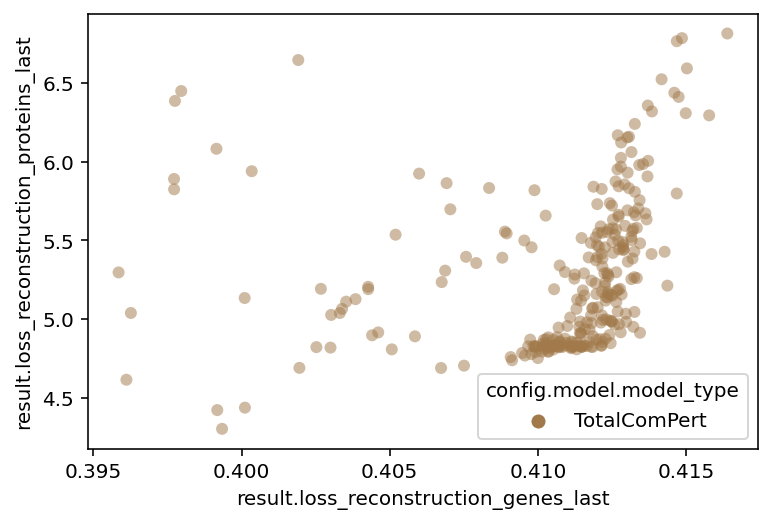

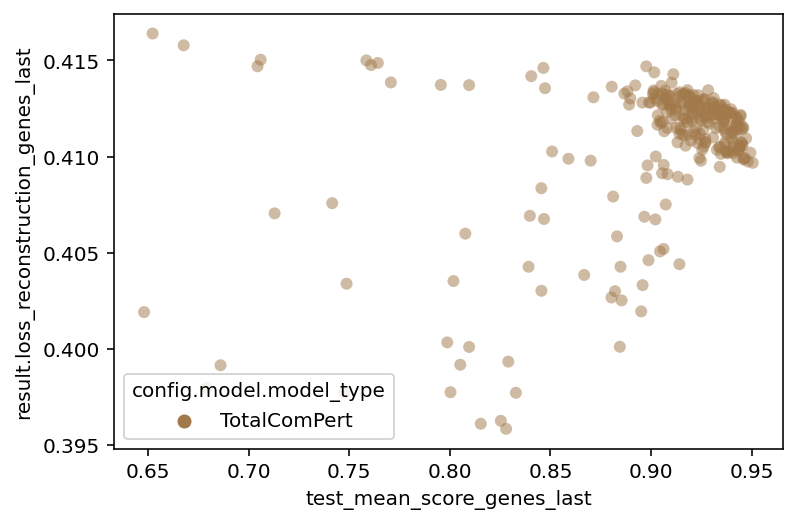

In [14]:
sns.scatterplot(data=df, x="result.loss_reconstruction_genes_last", y="result.loss_reconstruction_proteins_last", hue="config.model.model_type", **_sett)
#plt.xlim([0.54,0.56])
#plt.ylim([5,6])
plt.show()

sns.scatterplot(data=df, y="result.loss_reconstruction_genes_last", x=f"{'test'}_mean_score_genes_last", hue="config.model.model_type", **_sett)
#plt.ylim([0.54,0.56])
plt.show()

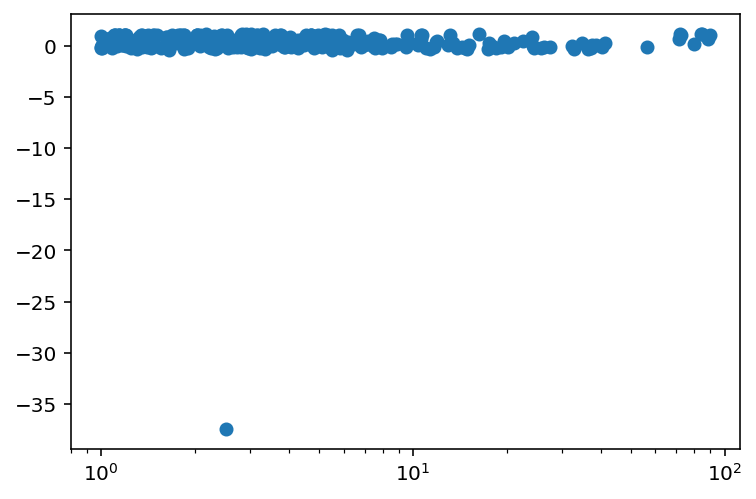

In [15]:
the_df = df[df["status"] == 1]
plt.scatter(the_df["config.model.model_args.hparams.recon_weight_pro"],
            the_df[f"{'test'}_mean_score_proteins_last"] / the_df[f"{'test'}_mean_score_genes_last"],
           )
plt.xscale('log')
#plt.yscale('log')
plt.show()

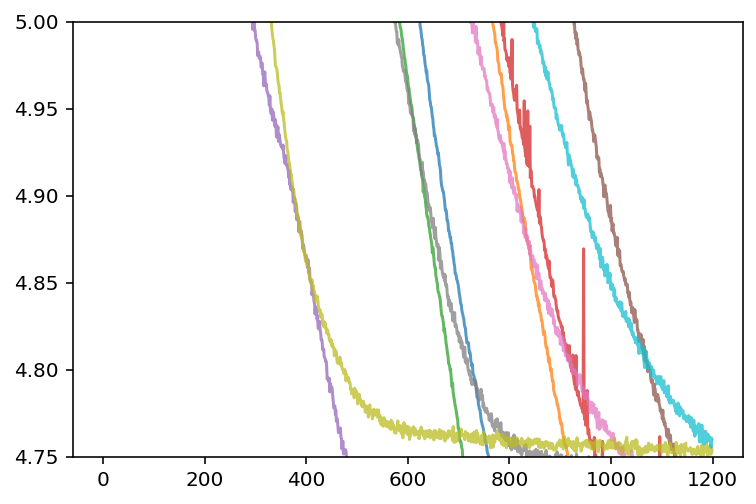

In [16]:
focus_metric = f"result.loss_reconstruction_proteins_last"
plt_metric = "result.loss_reconstruction_proteins"
top_top = 10

the_df = df[df["status"] == 1]
the_df = the_df.sort_values(by=[focus_metric], ascending=True)
the_df.reset_index(drop=True, inplace=True)
d = the_df[plt_metric][:top_top].to_list()
for i in d:
    plt.plot(i, alpha = 0.75)
    #plt.yscale('log')
plt.ylim([4.75,5])
plt.show()

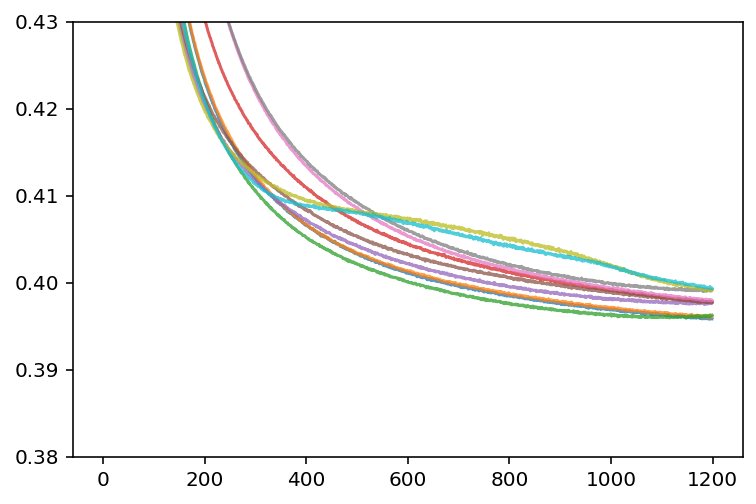

In [17]:
focus_metric = f"result.loss_reconstruction_genes_last"
plt_metric = "result.loss_reconstruction_genes"
top_top = 10

the_df = df[df["status"] == 1]
the_df = the_df.sort_values(by=[focus_metric], ascending=True)
the_df.reset_index(drop=True, inplace=True)
d = the_df[plt_metric][:top_top].to_list()
for i in d:
    plt.plot(i, alpha = 0.75)
    #plt.yscale('log')
plt.ylim([0.38,0.43])
plt.show()

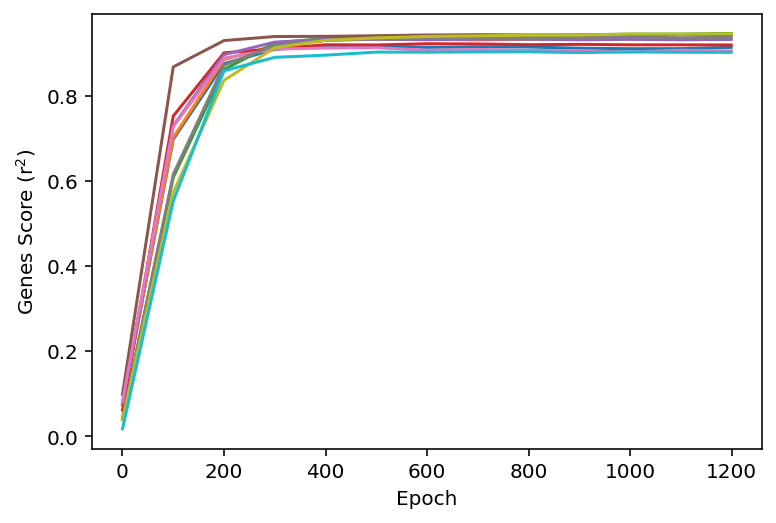

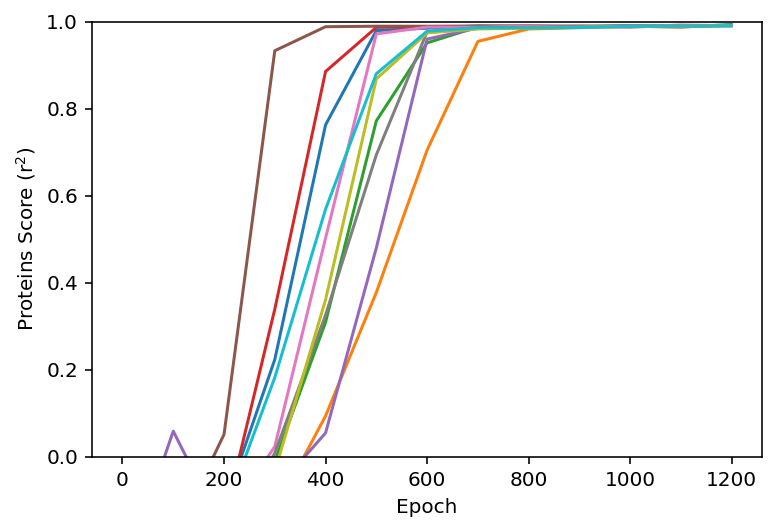

In [18]:
focus_metric = f"{'test'}_mean_score_proteins_last"
the_df = the_df.sort_values(by=[focus_metric], ascending=False)

x= the_df["result.stats_epoch"][:top_top].to_list()
d = the_df["test_mean_score_genes"][:top_top].to_list()
for ind, i in enumerate(d):
    plt.plot(x[ind], i)
    #plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel(r'Genes Score (r$^2)$')
plt.show()

d = the_df["test_mean_score_proteins"][:top_top].to_list()
for i in d:
    plt.plot(x[ind], i)
    #plt.xscale('log')
    plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel(r'Proteins Score (r$^2)$')
plt.show()

In [19]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(the_df.iloc[0,:])

## Which genes does not fit

- import top N model
- find a metric and compare predicted vs real gene values
- which genes are they? highly expressed etc?

In [20]:
focus_metric = f"{'test'}_mean_score_genes_last"
top_top = 10
the_df = df[df["status"] == 1]
the_df = the_df.sort_values(by=[focus_metric], ascending=False)[:top_top]
indices = the_df.index

In [21]:
model_dir = f"/storage/groups/ml01/workspace/kemal.inecik/seml/{se}/_last/"
#model_dir = "/home/icb/kemal.inecik/work/codes/mulpert/seml/_last/"
dataset_relative_to = "/home/icb/kemal.inecik/work/codes/multicpa-reproducibility"

In [22]:
the_df[[f"{'training'}_mean_score_genes_last", f"{'training'}_mean_score_proteins_last", 
        f"{'test'}_mean_score_genes_last", f"{'test'}_mean_score_proteins_last"]]

,training_mean_score_genes_last,training_mean_score_proteins_last,test_mean_score_genes_last,test_mean_score_proteins_last
_id,,,,
12600,0.979036,0.992201,0.950628,0.989438
349,0.978417,0.965607,0.949424,0.952422
618,0.977103,0.730224,0.948182,0.707247
575,0.974929,0.944737,0.947320,0.934957
523,0.974262,0.997580,0.946808,0.991967
146,0.974326,0.997993,0.946064,0.990685
161,0.974665,0.997942,0.945947,0.988619
459,0.972673,0.969976,0.945920,0.933967
55,0.972489,0.987127,0.945660,0.985342


#### proteins

######
12600


/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility/notebooks/../../multicpa/MultiCPA/data.py:107: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/torch/csrc/utils/tensor_new.cpp:201.)



True

[0.9892893539613018, 0.9012110938009995, 0.9507165276294278]
0.9894384177074032



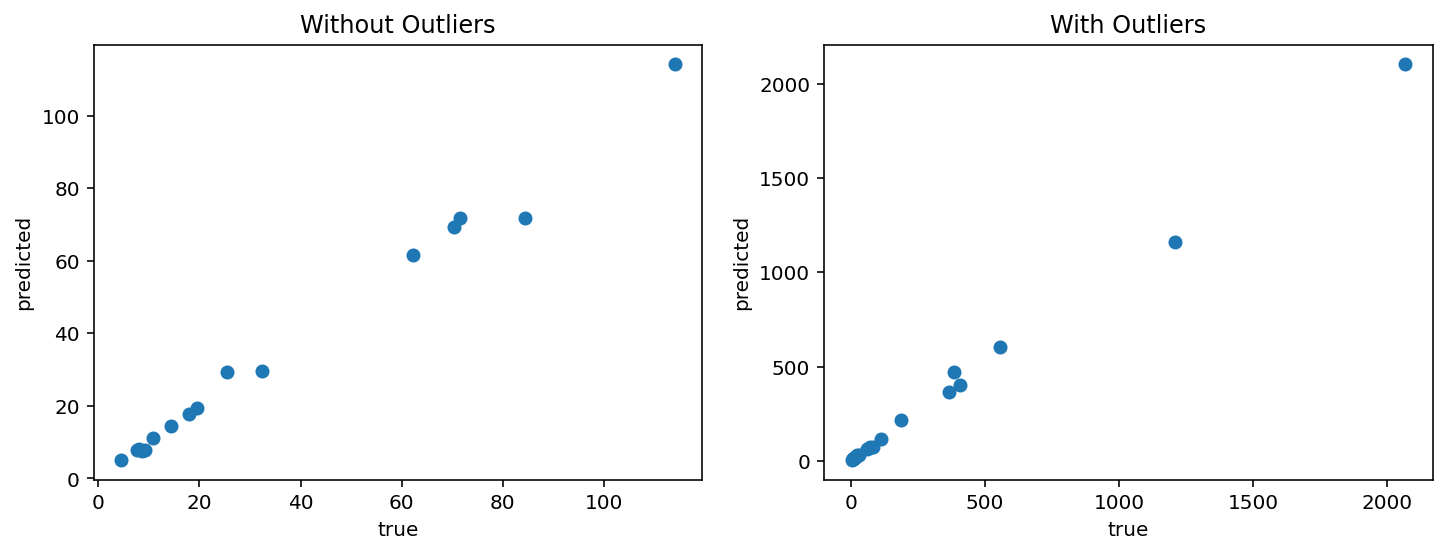

0.9973688451832795
0.9890188238956283
######
349
True

[0.9524161248618547, 0.8963673204551456, 0.9494701850278695]
0.9524219224723475



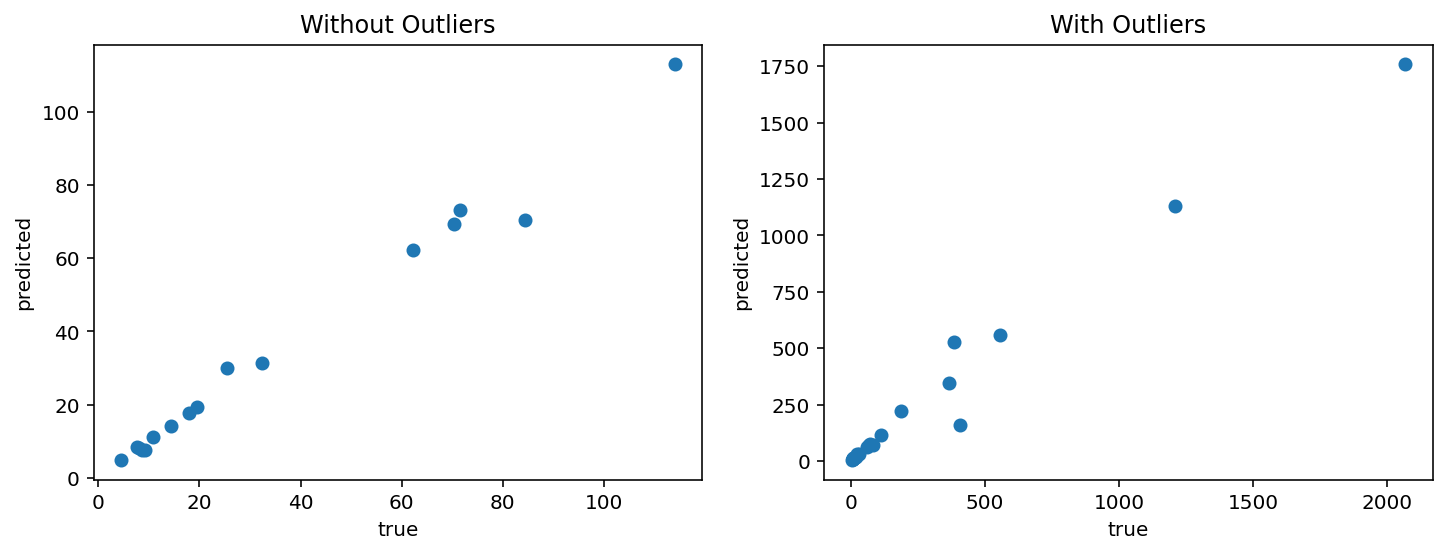

0.9636935760148398
0.9870259548198805


In [23]:
THR = 150
for mID in indices[:2]:
    print("######")
    print(mID)
    autoencoder, datasets, state, history, hypers = model_importer(mID, df, model_dir=model_dir, dataset_relative_to=dataset_relative_to)
    print(hypers['hparams']['adversary_wd'] == df.loc[mID]['config.model.model_args.hparams.adversary_wd'])

    dataset = datasets["test_treated"]
    genes_control = datasets["test_control"].raw_genes
    proteins_control = datasets["test_control"].raw_proteins
    num, dim_genes = genes_control.size(0), genes_control.size(1)
    dim_proteins = proteins_control.size(1)

    mean_score_proteins = []
    mean_score_genes = []
    mean_score_genes_de = []
    for pert_category in np.unique(dataset.pert_categories):
        de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
        idx = np.where(dataset.pert_categories == pert_category)[0]
        if len(idx) <= 30:
            pass
            #print(f"{pert_category}", end="\t")
        else:
            emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
            emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

            gene_predictions, protein_predictions = autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
            gene_predictions = gene_predictions.detach().cpu()
            protein_predictions = protein_predictions.detach().cpu()

            mean_predict_genes = gene_predictions[:, :dim_genes]
            mean_predict_proteins = protein_predictions[:, :dim_proteins]

            y_true_genes = dataset.raw_genes[idx, :].numpy()
            yt_m_genes = y_true_genes.mean(axis=0)
            yp_m_genes = np.array(mean_predict_genes.mean(0))
            mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
            mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))

            y_true_proteins = dataset.raw_proteins[idx, :].numpy()
            yt_m_proteins = y_true_proteins.mean(axis=0)
            yp_m_proteins = mean_predict_proteins.mean(0)
            mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))
    print()
    dd = pd.DataFrame([mean_score_proteins, mean_score_genes_de, mean_score_genes]).T
    print(list(dd.mean(axis=0)))
    print(df.loc[mID][f"{'test'}_mean_score_proteins_last"])
    print()
    plt.subplots(figsize=(12, 4))
    plt.subplot(1, 2, 2)
    plt.xlabel('true'); plt.ylabel('predicted')
    plt.scatter(yt_m_proteins, yp_m_proteins)
    plt.title('With Outliers')
    plt.subplot(1, 2, 1)
    inn = yt_m_proteins < THR
    ind = np.where(inn)
    plt.scatter(yt_m_proteins[ind], yp_m_proteins[ind])
    plt.xlabel('true'); plt.ylabel('predicted')
    plt.title('Without Outliers')
    plt.show()

    print(r2_score(yt_m_proteins, yp_m_proteins))
    print(r2_score(yt_m_proteins[ind], yp_m_proteins[ind]))

#### genes

######
12600
True
0.9892893539613018
0.9894384177074032



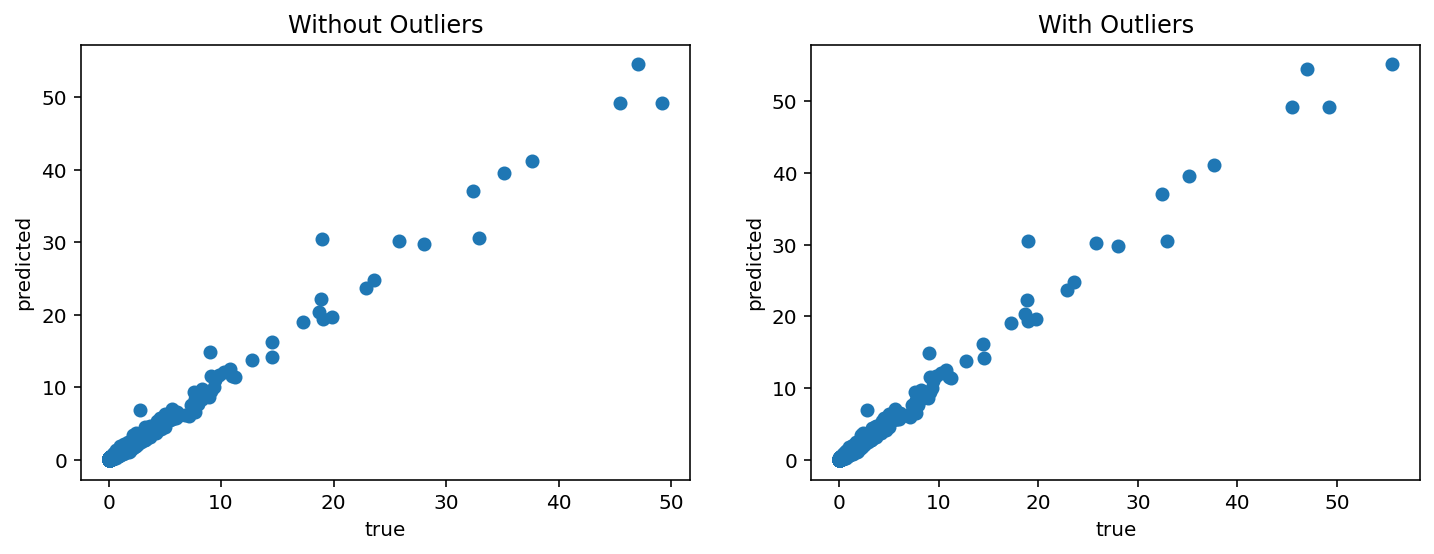

0.9804864317176164
0.9774986261411363
['LGALS1']
######
349
True
0.9524161248618547
0.9524219224723475



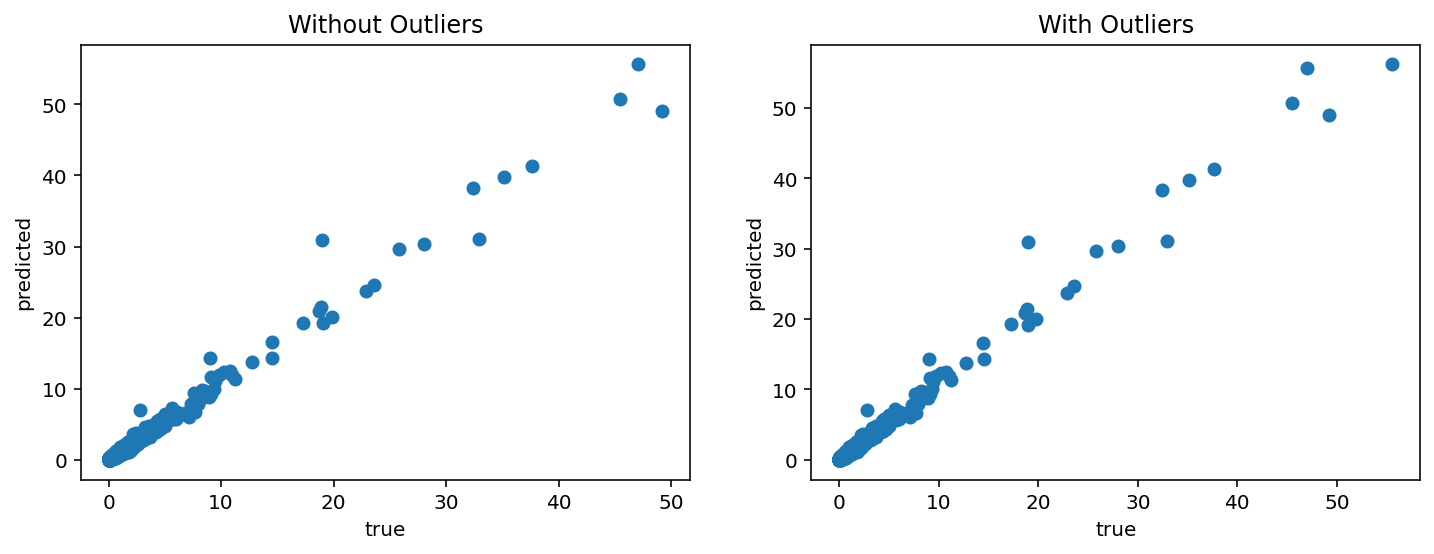

0.9777851924605995
0.9743873719371126
['LGALS1']


In [24]:
THR = 50
for mID in indices[:2]:
    print("######")
    print(mID)
    autoencoder, datasets, state, history, hypers = model_importer(mID, df, model_dir=model_dir, dataset_relative_to=dataset_relative_to)
    print(hypers['hparams']['adversary_wd'] == df.loc[mID]['config.model.model_args.hparams.adversary_wd'])

    dataset = datasets["test_treated"]
    genes_control = datasets["test_control"].raw_genes
    proteins_control = datasets["test_control"].raw_proteins
    num, dim_genes = genes_control.size(0), genes_control.size(1)
    dim_proteins = proteins_control.size(1)

    mean_score_proteins = []
    mean_score_genes = []
    mean_score_genes_de = []
    for pert_category in np.unique(dataset.pert_categories):
        de_idx = np.where(dataset.var_names.isin(np.array(dataset.de_genes[pert_category])))[0]
        idx = np.where(dataset.pert_categories == pert_category)[0]
        if len(idx) <= 30:
            pass
            #print(f"{pert_category}", end="\t")
        else:
            emb_drugs = dataset.drugs[idx][0].view(1, -1).repeat(num, 1).clone()
            emb_cts = dataset.cell_types[idx][0].view(1, -1).repeat(num, 1).clone()

            gene_predictions, protein_predictions = autoencoder.predict(genes_control, emb_drugs, emb_cts, proteins_control)
            gene_predictions = gene_predictions.detach().cpu()
            protein_predictions = protein_predictions.detach().cpu()

            mean_predict_genes = gene_predictions[:, :dim_genes]
            mean_predict_proteins = protein_predictions[:, :dim_proteins]

            y_true_genes = dataset.raw_genes[idx, :].numpy()
            yt_m_genes = y_true_genes.mean(axis=0)
            yp_m_genes = np.array(mean_predict_genes.mean(0))
            mean_score_genes.append(r2_score(yt_m_genes, yp_m_genes))
            mean_score_genes_de.append(r2_score(yt_m_genes[de_idx], yp_m_genes[de_idx]))

            y_true_proteins = dataset.raw_proteins[idx, :].numpy()
            yt_m_proteins = y_true_proteins.mean(axis=0)
            yp_m_proteins = mean_predict_proteins.mean(0)
            mean_score_proteins.append(r2_score(yt_m_proteins, yp_m_proteins))

    dd = pd.DataFrame([mean_score_proteins, mean_score_genes_de, mean_score_genes]).T
    print(dd.mean(axis=0)[0])
    print(df.loc[mID][f"{'test'}_mean_score_proteins_last"])
    print()
    plt.subplots(figsize=(12, 4))
    plt.subplot(1, 2, 2)
    plt.xlabel('true'); plt.ylabel('predicted')
    plt.scatter(yt_m_genes, yp_m_genes)
    plt.title('With Outliers')
    plt.subplot(1, 2, 1)
    inn = yt_m_genes < THR
    ind = np.where(inn)
    plt.scatter(yt_m_genes[ind], yp_m_genes[ind])
    plt.xlabel('true'); plt.ylabel('predicted')
    plt.title('Without Outliers')
    plt.show()

    print(r2_score(yt_m_genes, yp_m_genes))
    print(r2_score(yt_m_genes[ind], yp_m_genes[ind]))
    print(list(dataset.var_names[np.invert(inn)]))

## All in one

In [25]:
focus_metric = f"{'test'}_mean_score_genes_last"    
coords = choice_hypers + loguinform_hypers
to_go = coords + ["status", focus_metric]
lab = {to_go[i]: i+1 for i in range(len(to_go))}
df_toplot = df[to_go].copy()

In [26]:
#df_toplot = df_toplot[df_toplot[focus_metric] > 0.5]

In [27]:
df_toplot = df_toplot[df_toplot["config.model.model_type"].isin(["TotalComPert", "TotalPoEComPert", "ComPert", "PoEComPert"])]
sorted(df_toplot["config.model.model_type"].unique())

['TotalComPert']

In [28]:
focus_metric

'test_mean_score_genes_last'

In [29]:
for i in df_toplot.columns:
    try:
        df_toplot[i] = df_toplot[i].astype(float)
    except ValueError:
        un = sorted(df_toplot[i].unique())
        for ind, u in enumerate(un):
            df_toplot[i].replace(u, ind, inplace=True)

for i in loguinform_hypers:
    df_toplot[i] = np.log10(df_toplot[i])

In [30]:
try:
    max_score = max(df_toplot[focus_metric][df_toplot[focus_metric] != _to_fill])
except NameError:
    max_score = max(df_toplot[focus_metric])
max_score

nan

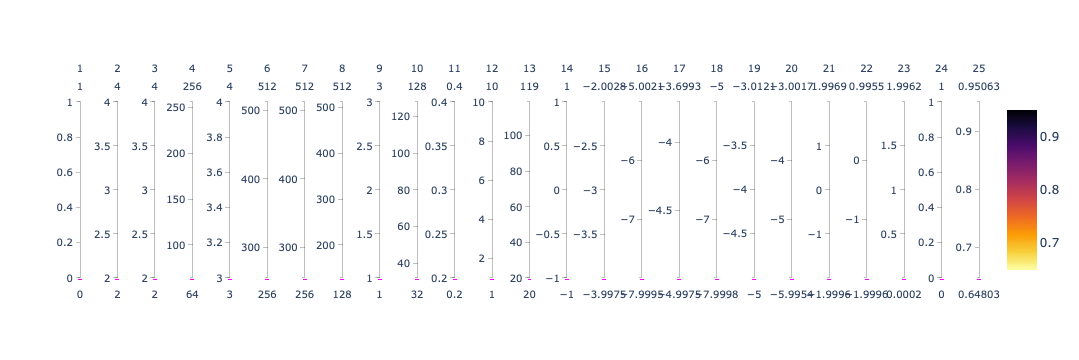

1: config.model.model_args.doser_type
2: config.model.model_args.hparams.adversary_depth
3: config.model.model_args.hparams.adversary_steps
4: config.model.model_args.hparams.adversary_width
5: config.model.model_args.hparams.autoencoder_depth
6: config.model.model_args.hparams.autoencoder_width
7: config.model.model_args.hparams.batch_size
8: config.model.model_args.hparams.dim
9: config.model.model_args.hparams.dosers_depth
10: config.model.model_args.hparams.dosers_width
11: config.model.model_args.hparams.kl_annealing_frac
12: config.model.model_args.hparams.kl_weight
13: config.model.model_args.hparams.step_size_lr
14: config.model.model_type
15: config.model.model_args.hparams.dosers_lr
16: config.model.model_args.hparams.dosers_wd
17: config.model.model_args.hparams.autoencoder_lr
18: config.model.model_args.hparams.autoencoder_wd
19: config.model.model_args.hparams.adversary_lr
20: config.model.model_args.hparams.adversary_wd
21: config.model.model_args.hparams.reg_adversary
22

In [31]:
_lst = [dict(label = lab[i], values=df_toplot[i]) for i in to_go]

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_toplot[focus_metric],
                    colorscale = 'Inferno_r',
                    showscale = True,
                    #cauto  = False,
                    cmax = max_score,
                    ),
        dimensions = _lst,
    )
)
fig.show()

for i in lab:
    print(f"{lab[i]}: {i}")

## Separate

In [ ]:
df_toplot_ = df_toplot[df_toplot['status'] == 1]

In [ ]:
sns.histplot(df_toplot_['config.model.model_args.hparams.autoencoder_lr'])

In [ ]:
focus_metric

In [ ]:
for i in lab:
    sns.jointplot(data=df_toplot_, x=focus_metric, y=i)
    plt.show()

https://plotly.com/python/parallel-categories-diagram/

## Categoricals

In [ ]:
df_toplot = df[to_go].copy()

In [ ]:
focus_metric = "mean_score_genes"
df_toplot[focus_metric]
fm = np.array(df_toplot[focus_metric][:len(df_c)])
p100 = np.percentile(fm, 100)
p90 = np.percentile(fm, 90)
p50 = np.percentile(fm, 50)
p0 = np.percentile(fm, 0)

arr = pd.DataFrame(np.ones(len(df_c)))
arr[(fm>p90)] = 1.0
arr[(fm<=p90)] = 0.0
#arr[(fm<=p60) & (fm>=p0)] = 0.3

only_comp = df_toplot[:len(df_c)].copy()
only_comp[focus_metric + "_bins"] = arr.astype(float)


In [ ]:
color = only_comp[focus_metric + "_bins"];

_lst = [go.parcats.Dimension(label = lab[i], 
                             values=only_comp[i],
                            categoryorder='category ascending',) for i in choice_hypers + ["status"]]

fig = go.Figure(data = [
    go.Parcats(dimensions=_lst[7:14] ,
        line={'color': color, 'colorscale': [[1.0, 'black'], [0.0, 'green']], 'showscale' : False,},
        )])

fig.show()

In [ ]:
# Create parcats trace
color = df_toplot['status'];
colorscale = [[0.0, 'gray'], [1.0, 'yellow']];

_lst = [go.parcats.Dimension(label = lab[i], 
                             values=df_toplot[i],
                            categoryorder='category ascending',) for i in choice_hypers + ["status"]]

fig = go.Figure(data = [
    go.Parcats(dimensions=_lst[5:10],
        line={'color': color, 'colorscale': colorscale},
        )])

fig.show()